In [1]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

def get_clip_embeddings(image_path, text_caption):
    # Load the model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    image = Image.open(image_path).convert("RGB")

    inputs = processor(text=[text_caption], images=image, return_tensors="pt", padding=True)

    # Generate embeddings
    outputs = model(**inputs)
    image_embedding = outputs.image_embeds
    text_embedding = outputs.text_embeds

    return image_embedding, text_embedding

image_path = '/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/img/run_1/frame_0.jpg'
text_caption = 'a woman is walking with a bear on the street'
image_embedding, text_embedding = get_clip_embeddings(image_path, text_caption)

print("Image Embedding:", image_embedding)
print("Text Embedding:", text_embedding)



/Users/aahd/miniconda3/envs/mind-video/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aahd/miniconda3/envs/mind-video/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Image Embedding: tensor([[ 4.9523e-02,  1.6182e-03,  2.6263e-02,  3.5968e-03, -1.6078e-02,
         -1.2900e-02,  2.3620e-02,  2.4393e-02, -4.5929e-02,  1.3874e-02,
          4.3165e-02, -2.4690e-02,  6.6577e-02,  1.9179e-02, -1.3157e-02,
          6.3523e-02, -5.5219e-02,  1.6836e-02, -2.0199e-02, -2.5446e-02,
          4.7008e-02,  2.0423e-02,  6.2202e-03, -2.5391e-02, -6.2111e-03,
          2.2841e-02,  1.1178e-02, -4.8789e-02, -4.8948e-03,  3.4896e-03,
         -7.9675e-04, -1.7625e-02,  8.9592e-04, -4.5497e-02,  5.4592e-02,
          5.9885e-02, -1.1826e-02,  4.2278e-02,  1.6784e-02,  5.9037e-02,
         -4.2587e-02,  5.5554e-02,  2.5691e-02,  2.7355e-02,  1.6297e-03,
          1.9303e-01,  4.6467e-02, -2.0630e-02,  2.5165e-02, -1.0277e-03,
          4.2383e-02, -2.5552e-02,  2.3903e-02, -2.2580e-02,  4.4930e-02,
          2.3316e-02,  1.6530e-02,  5.5655e-02,  5.7175e-03, -2.6085e-02,
         -7.6519e-02, -9.3744e-03,  2.0890e-02,  6.7906e-02,  1.5233e-02,
          3.3799e-02,

In [2]:
#shape of the embeddings
print(image_embedding.shape)
print(text_embedding.shape)

torch.Size([1, 512])
torch.Size([1, 512])


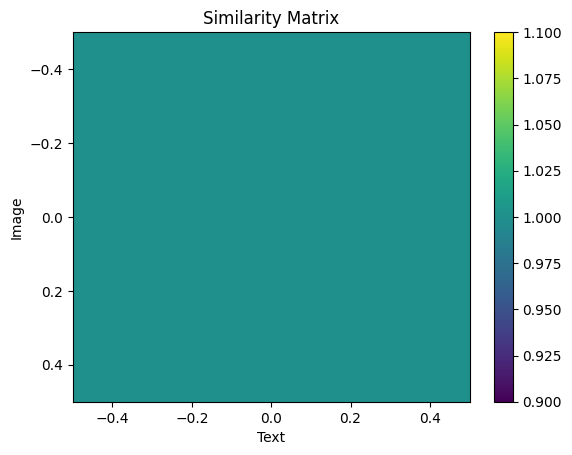

In [3]:
import matplotlib.pyplot as plt


def plot_similarity(image_embedding, text_embedding):
    similarity = (image_embedding @ text_embedding.T).softmax(dim=1)

    plt.imshow(similarity.detach().numpy(), cmap="viridis", aspect="auto")
    plt.xlabel("Text")
    plt.ylabel("Image")
    plt.title("Similarity Matrix")
    plt.colorbar()
    plt.show()
    
plot_similarity(image_embedding, text_embedding)

    

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim


class EmbeddingProjector(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EmbeddingProjector, self).__init__()
        self.projector = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.projector(x)

text_projector = EmbeddingProjector(input_dim=512, output_dim=768)
image_projector = EmbeddingProjector(input_dim=512, output_dim=768)

text_embeddings = torch.randn(1, 512)  # Simulated text embeddings from CLIP
image_embeddings = torch.randn(1, 512)  # Simulated image embeddings from CLIP
fMRI_embeddings = torch.randn(77, 768)  # Simulated fMRI embeddings

# Project the embeddings
projected_text_embeddings = text_projector(text_embeddings)
projected_image_embeddings = image_projector(image_embeddings)

pooled_fMRI_embeddings = fMRI_embeddings.mean(dim=0, keepdim=True)  # Results in a shape of (1, 768)

print("Projected Text Embeddings:", projected_text_embeddings.shape)
print("Projected Image Embeddings:", projected_image_embeddings.shape)
print("Pooled fMRI Embeddings:", pooled_fMRI_embeddings.shape)



Projected Text Embeddings: torch.Size([1, 768])
Projected Image Embeddings: torch.Size([1, 768])
Pooled fMRI Embeddings: torch.Size([1, 768])


In [5]:
# Dummy target for example purposes
target = torch.tensor([1])

loss_function = nn.MSELoss()
loss = loss_function(projected_text_embeddings, pooled_fMRI_embeddings)  # example loss computation

optimizer = optim.Adam(list(text_projector.parameters()) + list(image_projector.parameters()), lr=0.001)

optimizer.zero_grad()
loss.backward()
optimizer.step()


In [6]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, output_dim=768):
        super(ProjectionHead, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.GELU()
        self.norm = nn.LayerNorm(output_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        x = self.norm(x)
        return x


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/aahd/miniconda3/envs/mind-video/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing Video and Text Pairs: 100%|██████████| 1200/1200 [02:18<00:00,  8.64it/s]


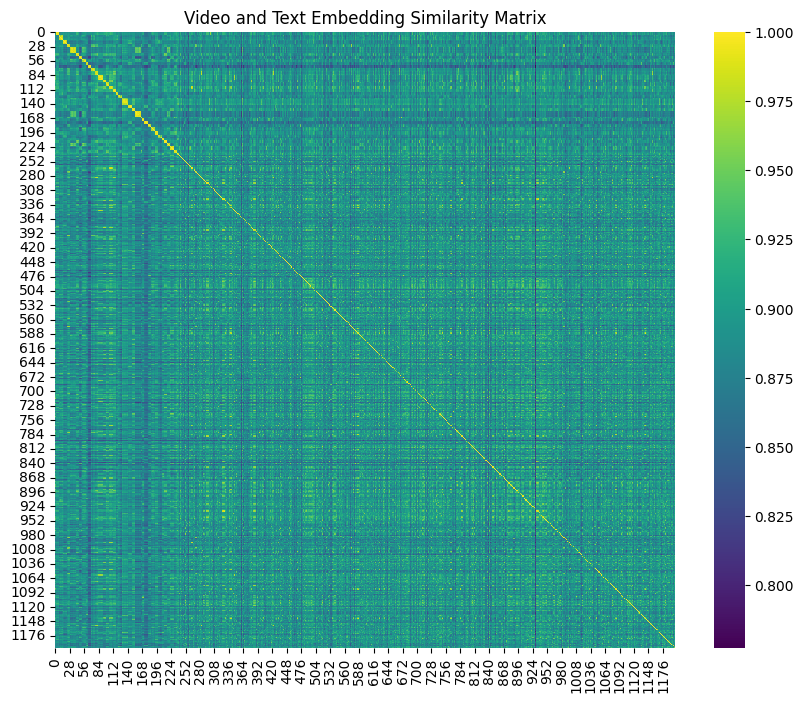

In [8]:
import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = "cpu"

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, output_dim=768):
        super(ProjectionHead, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim).to(device)
        self.activation = nn.GELU()
        self.norm = nn.LayerNorm(output_dim).to(device)

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        x = self.norm(x)
        return x

def load_clip_model_and_projection_heads():
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    image_projection_head = ProjectionHead().to(device)
    text_projection_head = ProjectionHead().to(device)
    return model, processor, image_projection_head, text_projection_head

def get_clip_embeddings(model, processor, projection_heads, image_tensor, text_caption):
    image_projection_head, text_projection_head = projection_heads
    inputs = processor(text=[text_caption], images=image_tensor, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    image_embedding = image_projection_head(outputs.image_embeds.squeeze().detach())
    text_embedding = text_projection_head(outputs.text_embeds.squeeze().detach())
    return image_embedding, text_embedding

def cosine_similarity_matrix(embeddings):
    normalized_embeddings = embeddings / embeddings.norm(dim=1)[:, None]
    similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.transpose(0, 1))
    return similarity_matrix

def process_embeddings(video_frames, text_ids, model, processor, projection_heads):
    combined_embeddings = []
    total_segments = video_frames.shape[0] * video_frames.shape[1]
    progress_bar = tqdm(total=total_segments, desc="Processing Video and Text Pairs")
    for i in range(video_frames.shape[0]):
        for j in range(video_frames.shape[1]):
            frame = video_frames[i, j, 0]  # Taking the first frame of each segment
            text = "Sample text"  # Placeholder for actual text extraction logic
            image_tensor = Image.fromarray(frame)
            image_embedding, text_embedding = get_clip_embeddings(model, processor, projection_heads, image_tensor, text)
            combined_embedding = torch.cat((image_embedding, text_embedding))
            combined_embeddings.append(combined_embedding)
            progress_bar.update(1)
    progress_bar.close()

    combined_embeddings_tensor = torch.stack(combined_embeddings).to(device)
    return cosine_similarity_matrix(combined_embeddings_tensor)

def plot_similarity(similarity_matrix, title):
    plt.figure(figsize=(10, 8))
    # Ensure the tensor is detached from the computation graph before converting it to NumPy
    sns.heatmap(similarity_matrix.cpu().detach().numpy(), cmap='viridis')
    plt.title(title)
    plt.show()

video_frames_path = '/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/wen_2018/video_test_256_3hz.npy'
segment_ids_path = '/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/wen_2018/test_seg_id_3hz.npy'
text_ids_path = '/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/wen_2018/text_test_256_3hz.npy'
fmri_ids_path = '/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/wen_2018/fmri_test_subject1.npy'


# Load data with progress bar
video_frames = np.load(video_frames_path)
text_ids = np.load(text_ids_path)

# Load model and projection heads
model, processor, image_projection_head, text_projection_head = load_clip_model_and_projection_heads()

# Process embeddings and plot similarity
similarity_matrix = process_embeddings(video_frames, text_ids, model, processor, (image_projection_head, text_projection_head))
plot_similarity(similarity_matrix, "Video and Text Embedding Similarity Matrix")
